# ROB2004 Final Project - pick and place objects

The goal of this project is to solve a simple manipulation task: picking up objects and moving them in a bowl.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.
* This is an individual project

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

You will need to install pybullet on your computer. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="500"/>
</div>

# Question

Implement a controller using the code skeletong below in order to get the robot to go and pick up the red blocks and drop them in the green bowl. The bowl position is ~~(-0.3,0.55,0.65)~~ $(-0.3,0.55,0.3)$ (in spatial frame coordinates) and the blocks positions are ~~(0.35,0.58,0.65)~~ $(0.35,0.58,0.3)$ and ~~(0.15,0.67,0.65)~~ $(0.15,0.67,0.3)$ respectively.

<div>
<img src="./manipulation_scene.jpg" width="800"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy and scipy
* You need to use at least one controller in the end-effector space
* You need to generate smooth motions
* You need to compensate for the gravity of the robot

In your report, describe the controller and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit).

In [1]:
import numpy as np
import time
import scipy as sp

import matplotlib.pyplot as plt

from panda import Simulator, PandaRobot

np.set_printoptions(precision=4, suppress = True)

# Helper functions

We provide a set of helper functions (forward kinematics, Jacobians, gravity terms) that can be used to implement the desired controllers. These functions are implemented in the PandaRobot class (in the panda.py file).
Examples are shown below:

In [2]:
# create an instance of the helper class
my_robot = PandaRobot()

# compute the forward kinematics for an arbitrary joint configuration
q = np.random.uniform(-1,1,7)
pose = my_robot.FK(np.array([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0]))
print(f'the pose of the end-effector for joint configuration\n\n {q}\n\n is\n\n {pose}')

the pose of the end-effector for joint configuration

 [-0.7856  0.1768 -0.2524  0.3525  0.7032  0.0717 -0.7827]

 is

 [[-0.7071  0.7071  0.      0.    ]
 [ 0.7071  0.7071 -0.      0.5545]
 [-0.      0.     -1.      0.6245]
 [ 0.      0.      0.      1.    ]]


In [3]:
# we can also get the Jacobian in various frames 
# it is sufficient to pass the name of the frame as an argument as shown below

q = np.random.uniform(-1,1,7)

spatial_jacobian = my_robot.get_jacobian(q, 'S')
body_jacobian = my_robot.get_jacobian(q, 'B')

# we can even get the Jacobian in a frame place at the same position as the end-effector 
# frame but oriented like the spatial frame
oriented_jacobian = my_robot.get_jacobian(q, 'O')

print(f'for joint configuration \n\n {q} \n \n the spatial Jacobian is \n\n {spatial_jacobian}\n\n')
print(f'the body Jacobian is \n\n {body_jacobian}\n\n')
print(f'and the Jacobian in a frame placed at the same position as the end-effector but oriented like the spatial frame is\n\n {oriented_jacobian}')

for joint configuration 

 [-0.0524 -0.3891 -0.6137 -0.5436 -0.3254  0.1065  0.3262] 
 
 the spatial Jacobian is 

 [[ 0.     -0.9986 -0.0199  0.7885  0.3009  0.5757 -0.2185]
 [ 0.      0.0524 -0.3788 -0.5749  0.0509 -0.8058  0.0121]
 [ 1.      0.      0.9253 -0.2185  0.9523 -0.1389 -0.9758]
 [ 0.     -0.0174  0.1261  0.3873 -0.1552  0.8483  0.0419]
 [ 0.     -0.3325 -0.0066  0.523   0.201   0.6114 -0.0421]
 [ 0.      0.     -0.      0.0217  0.0383 -0.0313 -0.0099]]


the body Jacobian is 

 [[-0.09   -0.4041 -0.4286 -0.135   0.0952 -0.4432 -0.    ]
 [-0.1994 -0.8882 -0.0275  0.9903  0.0471  0.8964  0.    ]
 [-0.9758  0.2188 -0.9031  0.034  -0.9943  0.      1.    ]
 [ 0.1681  0.5256  0.0607 -0.2819  0.0438  0.0959 -0.    ]
 [-0.0274 -0.2501 -0.2338 -0.0371 -0.0886  0.0474 -0.    ]
 [-0.0099 -0.0443 -0.0217 -0.04   -0.     -0.088   0.    ]]


and the Jacobian in a frame placed at the same position as the end-effector but oriented like the spatial frame is

 [[ 0.     -0.9986 -0.0199  0.

In [4]:
# finally it is possible to compute the effect of gravity on the joints
# this can for example be used to do gravity compensation when controlling the robot

q = np.random.uniform(-1,1,7)

g = my_robot.g(q)

print(f'for joint configuration \n\n {q} \n \n the gravity force seen on the joints is \n \n {g}')

for joint configuration 

 [-0.0192 -0.7029  0.243  -0.2759  0.4999 -0.7227 -0.1211] 
 
 the gravity force seen on the joints is 
 
 [ -0.      30.1157  -1.3705 -12.89    -0.0847   0.557    0.    ]


# Interpolation for trajectory generation
In the last laboratory, we had to generate desired joint positions from an initial position $\theta_{init}$ at time $t=t_{init}$ to a goal position $\theta_{goal}$ at time $t=t_{end}$ to reach a desired goal with the end-effector.

It is generally not a good idea to just send the desired goal joint positions to the PD controller because if they are too far from the actual positions, the error will be large and a large torque will be applied on each motor. This will likely create a very jerky movement, potentially creating a very large torque on each joint which could damage the robot, its motors, etc.

Therefore, at every control cycle, it is desirable to compute a desired position to send to the PD controller which is "in-between" the initial and goal position. One straightforward manner to do this is to interpolate between the initial and goal position. For example, we could set
$$\theta_{des}(s) = \theta_{init} + s \cdot (\theta_{goal} - \theta_{init})$$
where $s \in [0,1]$. Doing so, when $s=0$ we get $\theta_{des} = \theta_{init}$ (i.e. the joint angle when we started the movement). When $s=1$, we get $\theta_{des} = \theta_{goal}$ (i.e. the position where we would like to end up). For any $s$ between 0 and 1, we generate a line segment between those two positions.

# Time parametrization of the trajectory
## Linear time parametrization
Now we would like to change $s$ as a function of time, i.e. find $s(t)$ for all $t$ starting from $t_{init}$ to $t_{goal}$ for a total duration of movement of $T = t_{goal} - t_{init}$. The simplest manner to set $s(t)$ is a linear parametrization, i.e. simply choosing 
$$ s(t) = \frac{t-t_{init}}{t_{goal} - t_{init}} = \frac{t-t_{init}}{T}$$ which would lead to a trajectory of the form

$$\theta_{des}(t) = \theta_{init} + \frac{t-t_{init}}{T} (\theta_{goal} - \theta_{init})$$.

Doing so implies that the desired velocity and acceleration of the joint will be 
$$\dot{\theta}_{des}(t) = \frac{1}{T} (\theta_{goal} - \theta_{init})$$
and
$$\ddot{\theta}_{des}(t) = 0$$

Therefore, a linear parametrization of time leads to constant desired velocity and zero desired acceleration. This is potentially problematic because we would like start the motion at rest (so the velocity should be 0) and would like to end our movement with 0 velocity.

The figure below show an example of a trajectory to go from position 0 to position 10 in $T=5$ seconds. Notice how the position starts and ends at the desired locations but that the velocity is constant.
<img src="./lin_interp.png" width="500">

## Time parametrization with acceleration and velocity constraints
In general, if we impose only velocity constraints, we might have non-zero accelerations which can be an issue when generating torques in the PD controller. We generally prefer also imposing acceleration constraints in addition to the other constraints. We then have the following 6 constraints:

$$s(t_{init}) = 0, \ \ s(t_{goal}) = 1$$
$$\dot{s}(t_{init}) = 0, \ \ \dot{s}(t_{goal}) = 0$$
$$\ddot{s}(t_{init}) = 0, \ \ \ddot{s}(t_{goal}) = 0$$

We now need to use a polynomial of at least 5th order to have enough open parameters. Our polynomial is then $$s(t) = a_0 + a_1 (t-t_{init}) + a_2 (t-t_{init})^2 + a_3 (t-t_{init})^3 + a_4 (t-t_{init})^4 + a_5 (t-t_{init})^5$$

As before, we can find the coefficients by solving for the constraints. We find that $a_0 = a_1 = a_2 = 0$, $a_3 = \frac{10}{T^3}$, $a_4 = \frac{-15}{T^4}$ and $a_5 = \frac{6}{T^5}$.
This gives the following desired position parametrized by time
$$\theta_{des}(t) = \theta_{init} + \left( \frac{10}{T^3} (t-t_{init})^3 + \frac{-15}{T^4} (t-t_{init})^4 + \frac{6}{T^5} (t-t_{init})^5 \right) \cdot (\theta_{goal} - \theta_{init})$$
The following desired velocity
$$\dot{\theta}_{des}(t) = \left( \frac{30}{T^3} (t-t_{init})^2 + \frac{-60}{T^4} (t-t_{init})^3 + \frac{30}{T^5} (t-t_{init})^4 \right) \cdot (\theta_{goal} - \theta_{init})$$
And the following desired acceleration
$$\ddot{\theta}_{des}(t) = \left( \frac{60}{T^3} (t-t_{init}) + \frac{-180}{T^4} (t-t_{init})^2 + \frac{120}{T^5} (t-t_{init})^3 \right)\cdot (\theta_{goal} - \theta_{init})$$

The figure below shows the same example as above but with the new parametrization (in green). Notice how all the start and end constraints are now fullfiled.
<img src="./fifth_interp.png" width="500">

In [5]:

def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    desired_position = 0
    desired_velocity = 0
    T = t_goal - t_init
    
    desired_position = position_init + ((10 / np.power(T, 3)) * np.power(t - t_init, 3) + (-15 / np.power(T, 4)) * np.power(t - t_init, 4) + (6 / np.power(T, 5)) * np.power(t - t_init, 5)) * (position_goal - position_init)
    
    desired_velocity = ((30 / np.power(T, 3)) * np.power(t - t_init, 2) + (-60 / np.power(T, 4)) * np.power(t - t_init, 3) + (30 / np.power(T, 5)) * np.power(t - t_init, 4)) * (position_goal - position_init)

    return desired_position, desired_velocity

# Code Skeleton for the simulation

Feel free to change the `run_time` variable to match your needs. The class `Simulator` contains all the code for the simulation. The code skeleton currently implement a simple PD controller in joint space that just keeps a desired current position.

Importantly you can control both the joints and the gripper of the robot:
* `simulator.send_joint_torque(joint_torques)` sends a vector of dimension 7 setting the torques of the joints
* `simulator.gripper_move(gripper_position)` sends a vector of dimension 2 setting the position of the fingers of the gripper. The fingers can have positions from 0 to 0.04cm (you can fully close the gripper by setting `simulator.gripper_move([0,0])` and fully open it by setting `simulator.gripper_move([0.04,0.04)`)

<div>
<img src="./Frank_Emika_Panda_robot_annotated.png" width="500"/>
</div>

In [6]:
l0 = 0.333
l1 = 0.316
l2 = 0.384
l3 = 0.0880
l4 = 0.107
l5 = 0.277
l6 = 0.0880

## Impedance Controller

In [7]:

# ============== Define some goals ==============

open_grip = np.array([0.04, 0.04])
close_grip = np.array([0, 0])

# ! S represents spatial frame here

first_red_block_goal_in_S = np.array([
    0.35,
    0.58,
    0.3
])

second_red_block_goal_in_S = np.array([
    0.15,
    0.67,
    0.3
])

bowl_goal_in_S = np.array([
    -0.3,
    0.55,
    0.3
])

# ===============================================

# ============== Define some constants ==============

p_0_in_S = np.array([
    0,
    l2+l3+l4,
    l0+l1
]) # initial position of the end effector


first_block_offset = np.array([
    0,
    0,
    0.15
]) 

second_block_offset = np.array([
    0,
    0,
    0.15
])

goal_offset = np.array([
    0,
    0,
    0.15 + 0.15
]) 

# ! K --> Spring constant 3by3
K = np.eye(3)
# To run on the real robot, use these values
K[0, 0] = 150
K[1, 1] = 150
K[2, 2] = 150

# ! D --> Damping coefficient 3by3
D = np.eye(3)
D[0, 0] = 40
D[1, 1] = 40
D[2, 2] = 40

# ===================================================


In [8]:
# here we create a simulation and reset the state of the robot
simulator = Simulator()
simulator.reset_state([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0])

# we create a robot object so we can use its helper functions
my_robot = PandaRobot()

# duration of the simulation
run_time = 30.

# simulation time step
dt = 0.005

num_steps = int(run_time/dt)

# we store information
ndofs = 7 # number of degrees of freedom (excluding the gripper)
measured_positions = np.zeros([num_steps,ndofs])
measured_velocities = np.zeros_like(measured_positions)
desired_torques = np.zeros_like(measured_positions)
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
time = np.zeros([num_steps])

# we will store the end effector position (desired and measured)
measured_end_effector_position = np.zeros([num_steps,3])
desired_end_effector_position = np.zeros([num_steps,3])

### this is the main control loop
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = simulator.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    ## controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO SOLVE THE TASK

    end_effector_pose = my_robot.FK(q)
    measured_end_effector_position[i,:] = end_effector_pose[0:3,3]
    
    
    if 0 <= time[i] < 3:
        # From 0 to 3 seconds, the robot moves towards the first red block dock
        t_init, t_final = 0, 3
        start_pos = p_0_in_S
        end_goal = first_red_block_goal_in_S + first_block_offset
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = close_grip    

    elif 3 <= time[i] < 5:
        # From 3 to 5 seconds, the robot moves towards the first red block
        t_init, t_final = 3, 5
        start_pos = first_red_block_goal_in_S + first_block_offset
        end_goal = first_red_block_goal_in_S
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = open_grip  

    elif 5 <= time[i] < 7:
        # From 5 to 7 seconds, grip the block the robot returns towards the first red block dock
        t_init, t_final = 5, 7
        start_pos = first_red_block_goal_in_S
        end_goal = first_red_block_goal_in_S + first_block_offset
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = close_grip  
        
    elif 7 <= time[i] < 12:
        # From 7 to 12 seconds, the robot moves towards the bowl offset
        t_init, t_final = 7, 12
        start_pos = first_red_block_goal_in_S + first_block_offset
        end_goal = bowl_goal_in_S + goal_offset
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = close_grip 
        
    elif 12 <= time[i] < 15:
        # From 12 to 15 seconds, the robot moves towards the base position
        t_init, t_final = 12, 15
        start_pos = bowl_goal_in_S + goal_offset
        end_goal = p_0_in_S
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = open_grip 
        
        
    elif 15 <= time[i] < 18:
        # From 15 to 18 seconds, the robot moves towards the second red block dock
        t_init, t_final = 15, 18
        start_pos = p_0_in_S
        end_goal = second_red_block_goal_in_S + second_block_offset
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = close_grip    

    elif 18 <= time[i] < 20:
        # From 18 to 20 seconds, the robot moves towards the second red block
        t_init, t_final = 18, 20
        start_pos = second_red_block_goal_in_S + second_block_offset
        end_goal = second_red_block_goal_in_S
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = open_grip  

    elif 20 <= time[i] < 22:
        # From 20 to 22 seconds, grip the block the robot returns towards the second red block dock
        t_init, t_final = 20, 22
        start_pos = second_red_block_goal_in_S
        end_goal = second_red_block_goal_in_S + second_block_offset
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = close_grip  
        
    elif 22 <= time[i] < 27:
        # From 22 to 27 seconds, the robot moves towards the bowl offset
        t_init, t_final = 22, 27
        start_pos = second_red_block_goal_in_S + second_block_offset
        end_goal = bowl_goal_in_S + goal_offset
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = close_grip 
        
    elif 27 <= time[i] <= 30:
        # From 27 to 30 seconds, the robot moves towards the base position
        t_init, t_final = 27, 30
        start_pos = bowl_goal_in_S + goal_offset
        end_goal = p_0_in_S
        p_ref, p_dot_ref = compute_trajectory(start_pos, end_goal, t_init, t_final, time[i])    
        gripper_position = open_grip 
        
            
    J_in_O_frame = my_robot.get_jacobian(q, 'O') # returns 6 by 7
    J_linear = J_in_O_frame[3:,:] # gets by 3 by 7

    # ! Convert joint velocity to cartesian velocity (xyz)
    v_of_jacobian = J_linear @ dq # dq is theta_dot

    gravity_compensation = my_robot.g(q)

    joint_torques = J_linear.T @ (K @ (p_ref - measured_end_effector_position[i,:]) + D @ (p_dot_ref - v_of_jacobian)) + gravity_compensation
            
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    simulator.send_joint_torque(joint_torques)
    simulator.gripper_move(gripper_position)
    simulator.step()

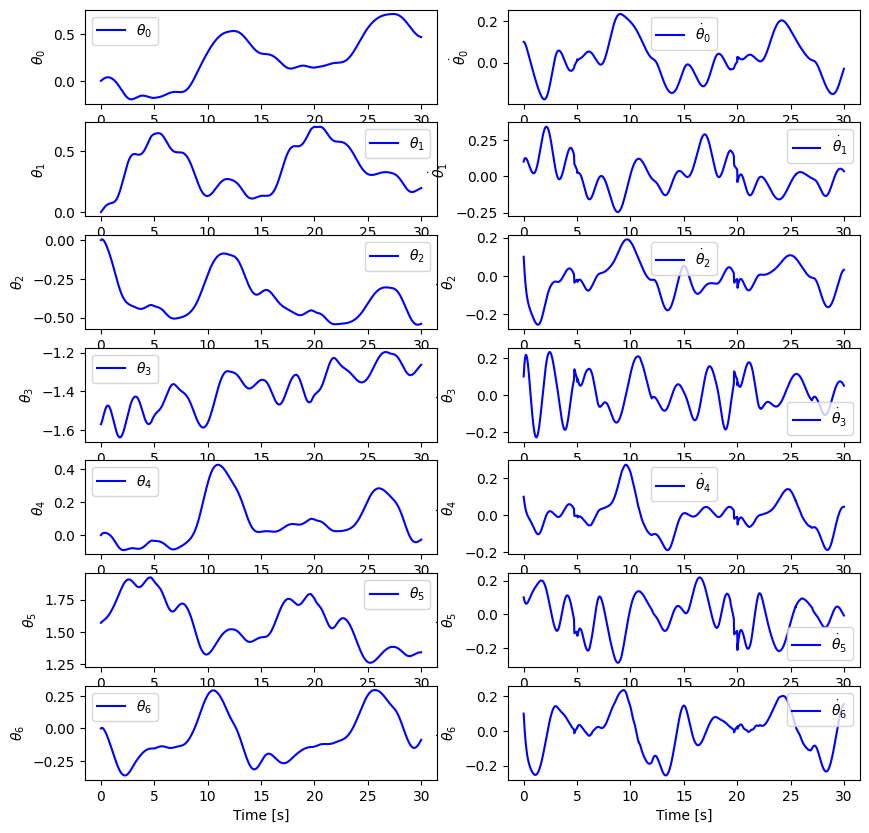

In [9]:
def plot_joint_posvel(time, th, dth):
    num_joints = th.shape[1]  # Get the number of joints dynamically
    
    fig, axes = plt.subplots(num_joints, 2, figsize=(10, 10))

    for i in range(num_joints):
        axes[i, 0].plot(time, th[:, i], 'b-', label=f'$\\theta_{i}$')
        axes[i, 0].set_ylabel(f'$\\theta_{i}$')
        axes[i, 0].legend()

        axes[i, 1].plot(time, dth[:, i], 'b-', label=f'$\\dot{{\\theta}}_{i}$')
        axes[i, 1].set_ylabel(f'$\\dot{{\\theta}}_{i}$')
        axes[i, 1].legend()

    axes[-1, 0].set_xlabel('Time [s]')
    axes[-1, 1].set_xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, measured_velocities)

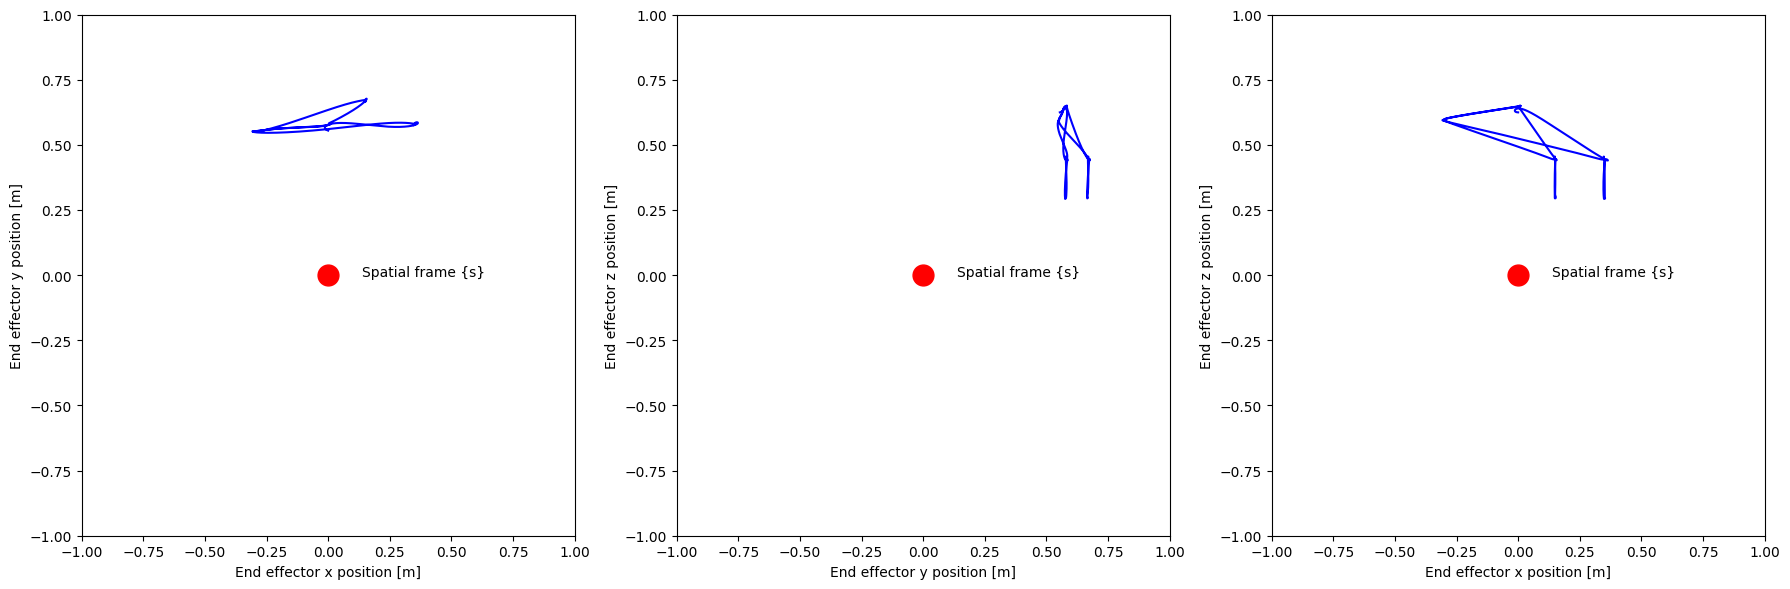

In [10]:
def plot_end_effector_trajectory(end_effector_position):
    """
    plots the position of the end_effector in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].plot(end_effector_position[:, 0], end_effector_position[:, 1], 'b')
    axes[0].set_xlabel('End effector x position [m]')
    axes[0].set_ylabel('End effector y position [m]')
    axes[0].set_xlim([-1, 1])
    axes[0].set_ylim([-1, 1])
    axes[0].plot([0], [0], 'o', markersize=15, color='r')
    
    # TODO change spatial frame below
    axes[0].annotate('Spatial frame {s}', xy=(-0.03, -0.005), xytext=(30, 0), textcoords='offset points')

    axes[1].plot(end_effector_position[:, 1], end_effector_position[:, 2], 'b')
    axes[1].set_xlabel('End effector y position [m]')
    axes[1].set_ylabel('End effector z position [m]')
    axes[1].set_xlim([-1, 1])
    axes[1].set_ylim([-1, 1])
    axes[1].plot([0], [0], 'o', markersize=15, color='r')
    
    # TODO change spatial frame below
    axes[1].annotate('Spatial frame {s}', xy=(-0.03, -0.005), xytext=(30, 0), textcoords='offset points')

    axes[2].plot(end_effector_position[:, 0], end_effector_position[:, 2], 'b')
    axes[2].set_xlabel('End effector x position [m]')
    axes[2].set_ylabel('End effector z position [m]')
    axes[2].set_xlim([-1, 1])
    axes[2].set_ylim([-1, 1])
    axes[2].plot([0], [0], 'o', markersize=15, color='r')
    
    # TODO change spatial frame below
    axes[2].annotate('Spatial frame {s}', xy=(-0.03, -0.005), xytext=(30, 0), textcoords='offset points')

    plt.tight_layout()
    plt.show()
    
plot_end_effector_trajectory(measured_end_effector_position)